In [46]:
import requests
import json
import pandas as pd
import os
import pickle
import numpy as np

api_key = "1ef6419e8402727a6b0819afe1bbd505e2e81792819363cb2fa355038f61cf6a" #gmail
api_key = "aa89bba56922c3c01dd25b6c04d18271922fbfd4021a086748a374b53d861693" # outlook
api_key = "51901b80841dbcc3949fc85fdc4c46370cee0062455e2bc5b765d7c26bc8436c"
#https://medium.com/@jan_5421/extracting-financial-statements-from-sec-filings-xbrl-to-json-f83542ade90

# XBRL-to-JSON converter API endpoint
xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"     

In [10]:
{
    "query": {
        "query_string": {
            "query": "ticker:(AAPL, TSLA, MSFT)"
        }
    },
    "from": "0",
    "size": "20",
    "sort": [{ "filedAt": { "order": "desc" } }]
}

{'query': {'query_string': {'query': 'ticker:(AAPL, TSLA, MSFT)'}},
 'from': '0',
 'size': '20',
 'sort': [{'filedAt': {'order': 'desc'}}]}

In [11]:


# 10-Q filing URL of Apple
filing_url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000056/aapl-20210327.htm"

# XBRL-to-JSON converter API endpoint
xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"

final_url = xbrl_converter_api_endpoint + "?htm-url=" + filing_url + "&token=" + api_key

# make request to the API
response = requests.get(final_url)

# load JSON into memory
xbrl_json = json.loads(response.text)

# income statement example
# print(json.dumps(xbrl_json['StatementsOfIncome']['RevenueFromContractWithCustomerExcludingAssessedTax'][0:2], indent=1))

In [12]:
xbrl_json

{'CoverPage': {'DocumentType': '10-Q',
  'DocumentQuarterlyReport': 'true',
  'DocumentPeriodEndDate': '2021-03-27',
  'DocumentTransitionReport': 'false',
  'EntityFileNumber': '001-36743',
  'EntityRegistrantName': 'Apple Inc.',
  'EntityIncorporationStateCountryCode': 'CA',
  'EntityTaxIdentificationNumber': '94-2404110',
  'EntityAddressAddressLine1': 'One Apple Park Way',
  'EntityAddressCityOrTown': 'Cupertino',
  'EntityAddressStateOrProvince': 'CA',
  'EntityAddressPostalZipCode': '95014',
  'CityAreaCode': '408',
  'LocalPhoneNumber': '996-1010',
  'Security12bTitle': [{'period': {'startDate': '2020-09-27',
     'endDate': '2021-03-27'},
    'segment': {'dimension': 'us-gaap:StatementClassOfStockAxis',
     'value': 'us-gaap:CommonStockMember'},
    'value': 'Common Stock, $0.00001 par value per share'},
   {'period': {'startDate': '2020-09-27', 'endDate': '2021-03-27'},
    'segment': {'dimension': 'us-gaap:StatementClassOfStockAxis',
     'value': 'aapl:A1.000NotesDue2022Mem

xbrl_json

In [13]:
# convert XBRL-JSON of income statement to pandas dataframe
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)                    

        income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T 

income_statement = get_income_statement(xbrl_json)
income_statement

,2020-12-27-2021-03-27,2019-12-29-2020-03-28,2020-09-27-2021-03-27,2019-09-29-2020-03-28
RevenueFromContractWithCustomerExcludingAssessedTax,89584000000,58313000000,201023000000,150132000000
CostOfGoodsAndServicesSold,51505000000,35943000000,118616000000,92545000000
GrossProfit,38079000000,22370000000,82407000000,57587000000
ResearchAndDevelopmentExpense,5262000000,4565000000,10425000000,9016000000
SellingGeneralAndAdministrativeExpense,5314000000,4952000000,10945000000,10149000000
OperatingExpenses,10576000000,9517000000,21370000000,19165000000
OperatingIncomeLoss,27503000000,12853000000,61037000000,38422000000
NonoperatingIncomeExpense,508000000,282000000,553000000,631000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,28011000000,13135000000,61590000000,39053000000
IncomeTaxExpenseBenefit,4381000000,1886000000,9205000000,5568000000


In [14]:

# convert XBRL-JSON of balance sheet to pandas dataframe
def get_balance_sheet(xbrl_json):
    balance_sheet_store = {}

    for usGaapItem in xbrl_json['BalanceSheets']:
        values = []
        indicies = []

        for fact in xbrl_json['BalanceSheets'][usGaapItem]:
            # only consider items without segment.
            if 'segment' not in fact:
                index = fact['period']['instant']

                # avoid duplicate indicies with same values
                if index in indicies:
                    continue
                    
                # add 0 if value is nil
                if "value" not in fact:
                    values.append(0)
                else:
                    values.append(fact['value'])

                indicies.append(index)                    

            balance_sheet_store[usGaapItem] = pd.Series(values, index=indicies) 

    balance_sheet = pd.DataFrame(balance_sheet_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date instant
    return balance_sheet.T

balance_sheet = get_balance_sheet(xbrl_json)
balance_sheet

,2019-09-28,2019-12-28,2020-03-28,2020-09-26,2020-12-26,2021-03-27
CashAndCashEquivalentsAtCarryingValue,NaN,NaN,NaN,38016000000,NaN,38466000000
MarketableSecuritiesCurrent,NaN,NaN,NaN,52927000000,NaN,31368000000
AccountsReceivableNetCurrent,NaN,NaN,NaN,16120000000,NaN,18503000000
InventoryNet,NaN,NaN,NaN,4061000000,NaN,5219000000
NontradeReceivablesCurrent,NaN,NaN,NaN,21325000000,NaN,14533000000
OtherAssetsCurrent,NaN,NaN,NaN,11264000000,NaN,13376000000
AssetsCurrent,NaN,NaN,NaN,143713000000,NaN,121465000000
MarketableSecuritiesNoncurrent,NaN,NaN,NaN,100887000000,NaN,134539000000
PropertyPlantAndEquipmentNet,NaN,NaN,NaN,36766000000,NaN,37815000000
OtherAssetsNoncurrent,NaN,NaN,NaN,42522000000,NaN,43339000000


In [15]:

def get_cash_flow_statement(xbrl_json):
    cash_flows_store = {}

    for usGaapItem in xbrl_json['StatementsOfCashFlows']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfCashFlows'][usGaapItem]:        
            # only consider items without segment.
            if 'segment' not in fact:
                # check if date instant or date range is present
                if "instant" in fact['period']:
                    index = fact['period']['instant']
                else:
                    index = fact['period']['startDate'] + '-' + fact['period']['endDate']

                # avoid duplicate indicies with same values
                if index in indicies:
                    continue

                if "value" not in fact:
                    values.append(0)
                else:
                    values.append(fact['value'])

                indicies.append(index)                    

        cash_flows_store[usGaapItem] = pd.Series(values, index=indicies) 


    cash_flows = pd.DataFrame(cash_flows_store)
    return cash_flows.T
    
cash_flows = get_cash_flow_statement(xbrl_json)
cash_flows

,2019-09-28,2019-09-29-2020-03-28,2019-12-29-2020-03-28,2020-03-28,2020-09-26,2020-09-27-2021-03-27,2020-12-27-2021-03-27,2021-03-27
CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents,50224000000,NaN,NaN,43049000000,39789000000,NaN,NaN,40006000000
NetIncomeLoss,NaN,33485000000,11249000000,NaN,NaN,52385000000,23630000000,NaN
DepreciationDepletionAndAmortization,NaN,5602000000,NaN,NaN,NaN,5463000000,NaN,NaN
ShareBasedCompensation,NaN,3407000000,NaN,NaN,NaN,4001000000,NaN,NaN
DeferredIncomeTaxExpenseBenefit,NaN,-651000000,NaN,NaN,NaN,-207000000,NaN,NaN
OtherNoncashIncomeExpense,NaN,259000000,NaN,NaN,NaN,474000000,NaN,NaN
IncreaseDecreaseInAccountsReceivable,NaN,-7284000000,NaN,NaN,NaN,2347000000,NaN,NaN
IncreaseDecreaseInInventories,NaN,-699000000,NaN,NaN,NaN,1226000000,NaN,NaN
IncreaseDecreaseInOtherReceivables,NaN,-7923000000,NaN,NaN,NaN,-6792000000,NaN,NaN
IncreaseDecreaseInOtherOperatingAssets,NaN,8866000000,NaN,NaN,NaN,4333000000,NaN,NaN


In [18]:
from sec_api import QueryApi

# get your API key at https://sec-api.io
query_api = QueryApi(api_key=api_key)

# fetch all 10-Q and 10-K filings for Apple
query = {
    "query": {
        "query_string": {
            "query": "(formType:\"10-Q\" OR formType:\"10-K\") AND ticker:AAPL"
        }
    },
    "from": "0",
    "size": "20",
    "sort": [{ "filedAt": { "order": "desc" } }]
}

query_result = query_api.get_filings(query)

In [38]:
accession_numbers = []

# extract accession numbers of each filing
for filing in query_result['filings']:
    accession_numbers.append(filing['accessionNo']);

accession_numbers

['0000320193-23-000064',
 '0000320193-23-000006',
 '0000320193-22-000108',
 '0000320193-22-000070',
 '0000320193-22-000059',
 '0000320193-22-000007',
 '0000320193-21-000105',
 '0000320193-21-000065',
 '0000320193-21-000056',
 '0000320193-21-000010',
 '0000320193-20-000096',
 '0000320193-20-000062',
 '0000320193-20-000052',
 '0000320193-20-000010',
 '0000320193-19-000119',
 '0000320193-19-000076',
 '0000320193-19-000066',
 '0000320193-19-000010',
 '0000320193-18-000145',
 '0000320193-18-000100']

In [20]:
import time

# get XBRL-JSON for a given accession number
def get_xbrl_json(accession_no, retry = 0):
    request_url = xbrl_converter_api_endpoint + "?accession-no=" + accession_no + "&token=" + api_key

    # linear backoff in case API fails with "too many requests" error
    try:
      response_tmp = requests.get(request_url)
      xbrl_json = json.loads(response_tmp.text)
    except:
      if retry > 5:
        raise Exception('API error')
      
      # wait 500 milliseconds on error and retry
      time.sleep(0.5) 
      return get_xbrl_json(accession_no, retry + 1)

    return xbrl_json

In [22]:
# clean income statement.
# drop duplicate columns (= column name ends with "_left"), drop key_0 column, drop columns with +5 NaNs
def clean_income_statement(statement):
    for column in statement:

        # column has more than 5 NaN values
        is_nan_column = statement[column].isna().sum() > 5

        if column.endswith('_left') or column == 'key_0' or is_nan_column:
            statement = statement.drop(column, axis=1)
    
    # rearrange columns so that first column represents first quarter
    # e.g. 2018, 2019, 2020 - and not 2020, 2019, 2018
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [23]:
# merge two income statements into one statement.
# row indicies of both statements have to be the same
# statement_b represents the most recent statement.
def merge_income_statements(statement_a, statement_b):
    return statement_a.merge(statement_b,
                     how="outer", 
                    #  on=statement_b.index, 
                    right_on=statement_b.index, 
                     left_index=True,
                    #  right_index=True,
                     suffixes=('_left', ''))

In [58]:
# helps printing dataframes while we generate new income statement
from IPython.display import display, HTML

previous_income_statement_set = False
income_statement_final = None

for accession_no in accession_numbers[0:12]:
# for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
    print('Processing: ' + accession_no)
    
    # get XBRL-JSON of 10-Q or 10-K filing by accession number
    # xbrl_json_data = get_xbrl_json(accession_no)
    xbrl_json_data = cacheDownload(f"datasets/balance_sheet_xbrl_{accession_no}",get_xbrl_json(accession_no)) #get_xbrl_json(accession_no)

    
    # convert XBRL-JSON to a pandas dataframe
    income_statement_uncleaned = get_income_statement(xbrl_json_data)

    # clean the income statement
    income_statement_cleaned = clean_income_statement(income_statement_uncleaned)
    
    # print income statement on each iteration to monitor progress
    display(HTML(income_statement_cleaned.to_html()))
    
    # merge new income statement with previously generated income statement
    if previous_income_statement_set:
        income_statement_final = clean_income_statement(merge_income_statements(income_statement_final, income_statement_cleaned))
    else:
        income_statement_final = income_statement_cleaned
        previous_income_statement_set = True

Processing: 0000320193-23-000064
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-23-000064


,2021-09-26-2022-03-26,2021-12-26-2022-03-26,2022-09-25-2023-04-01,2023-01-01-2023-04-01
RevenueFromContractWithCustomerExcludingAssessedTax,221223000000,97278000000,211990000000,94836000000
CostOfGoodsAndServicesSold,124421000000,54719000000,119682000000,52860000000
GrossProfit,96802000000,42559000000,92308000000,41976000000
ResearchAndDevelopmentExpense,12693000000,6387000000,15166000000,7457000000
SellingGeneralAndAdministrativeExpense,12642000000,6193000000,12808000000,6201000000
OperatingExpenses,25335000000,12580000000,27974000000,13658000000
OperatingIncomeLoss,71467000000,29979000000,64334000000,28318000000
NonoperatingIncomeExpense,-87000000,160000000,-329000000,64000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,71380000000,30139000000,64005000000,28382000000
IncomeTaxExpenseBenefit,11740000000,5129000000,9847000000,4222000000


Processing: 0000320193-23-000006
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-23-000006


,2021-09-26-2021-12-25,2022-09-25-2022-12-31
RevenueFromContractWithCustomerExcludingAssessedTax,123945000000,117154000000
CostOfGoodsAndServicesSold,69702000000,66822000000
GrossProfit,54243000000,50332000000
ResearchAndDevelopmentExpense,6306000000,7709000000
SellingGeneralAndAdministrativeExpense,6449000000,6607000000
OperatingExpenses,12755000000,14316000000
OperatingIncomeLoss,41488000000,36016000000
NonoperatingIncomeExpense,-247000000,-393000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,41241000000,35623000000
IncomeTaxExpenseBenefit,6611000000,5625000000


Processing: 0000320193-22-000108
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000108


,2019-09-29-2020-09-26,2020-09-27-2021-09-25,2021-09-26-2022-09-24
RevenueFromContractWithCustomerExcludingAssessedTax,274515000000,365817000000,394328000000
CostOfGoodsAndServicesSold,169559000000,212981000000,223546000000
GrossProfit,104956000000,152836000000,170782000000
ResearchAndDevelopmentExpense,18752000000,21914000000,26251000000
SellingGeneralAndAdministrativeExpense,19916000000,21973000000,25094000000
OperatingExpenses,38668000000,43887000000,51345000000
OperatingIncomeLoss,66288000000,108949000000,119437000000
NonoperatingIncomeExpense,803000000,258000000,-334000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,67091000000,109207000000,119103000000
IncomeTaxExpenseBenefit,9680000000,14527000000,19300000000


Processing: 0000320193-22-000070
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000070


,2020-09-27-2021-06-26,2021-03-28-2021-06-26,2021-09-26-2022-06-25,2022-03-27-2022-06-25
RevenueFromContractWithCustomerExcludingAssessedTax,282457000000,81434000000,304182000000,82959000000
CostOfGoodsAndServicesSold,164795000000,46179000000,171495000000,47074000000
GrossProfit,117662000000,35255000000,132687000000,35885000000
ResearchAndDevelopmentExpense,16142000000,5717000000,19490000000,6797000000
SellingGeneralAndAdministrativeExpense,16357000000,5412000000,18654000000,6012000000
OperatingExpenses,32499000000,11129000000,38144000000,12809000000
OperatingIncomeLoss,85163000000,24126000000,94543000000,23076000000
NonoperatingIncomeExpense,796000000,243000000,-97000000,-10000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,85959000000,24369000000,94446000000,23066000000
IncomeTaxExpenseBenefit,11830000000,2625000000,15364000000,3624000000


Processing: 0000320193-22-000059
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000059


,2020-09-27-2021-03-27,2020-12-27-2021-03-27,2021-09-26-2022-03-26,2021-12-26-2022-03-26
RevenueFromContractWithCustomerExcludingAssessedTax,201023000000,89584000000,221223000000,97278000000
CostOfGoodsAndServicesSold,118616000000,51505000000,124421000000,54719000000
GrossProfit,82407000000,38079000000,96802000000,42559000000
ResearchAndDevelopmentExpense,10425000000,5262000000,12693000000,6387000000
SellingGeneralAndAdministrativeExpense,10945000000,5314000000,12642000000,6193000000
OperatingExpenses,21370000000,10576000000,25335000000,12580000000
OperatingIncomeLoss,61037000000,27503000000,71467000000,29979000000
NonoperatingIncomeExpense,553000000,508000000,-87000000,160000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,61590000000,28011000000,71380000000,30139000000
IncomeTaxExpenseBenefit,9205000000,4381000000,11740000000,5129000000


Processing: 0000320193-22-000007
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000007


,2020-09-27-2020-12-26,2021-09-26-2021-12-25
RevenueFromContractWithCustomerExcludingAssessedTax,111439000000,123945000000
CostOfGoodsAndServicesSold,67111000000,69702000000
GrossProfit,44328000000,54243000000
ResearchAndDevelopmentExpense,5163000000,6306000000
SellingGeneralAndAdministrativeExpense,5631000000,6449000000
OperatingExpenses,10794000000,12755000000
OperatingIncomeLoss,33534000000,41488000000
NonoperatingIncomeExpense,45000000,-247000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,33579000000,41241000000
IncomeTaxExpenseBenefit,4824000000,6611000000


Processing: 0000320193-21-000105
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-21-000105


,2018-09-30-2019-09-28,2019-09-29-2020-09-26,2020-09-27-2021-09-25
RevenueFromContractWithCustomerExcludingAssessedTax,260174000000,274515000000,365817000000
CostOfGoodsAndServicesSold,161782000000,169559000000,212981000000
GrossProfit,98392000000,104956000000,152836000000
ResearchAndDevelopmentExpense,16217000000,18752000000,21914000000
SellingGeneralAndAdministrativeExpense,18245000000,19916000000,21973000000
OperatingExpenses,34462000000,38668000000,43887000000
OperatingIncomeLoss,63930000000,66288000000,108949000000
NonoperatingIncomeExpense,1807000000,803000000,258000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,65737000000,67091000000,109207000000
IncomeTaxExpenseBenefit,10481000000,9680000000,14527000000


Processing: 0000320193-21-000065
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-21-000065


,2019-09-29-2020-06-27,2020-03-29-2020-06-27,2020-09-27-2021-06-26,2021-03-28-2021-06-26
RevenueFromContractWithCustomerExcludingAssessedTax,209817000000,59685000000,282457000000,81434000000
CostOfGoodsAndServicesSold,129550000000,37005000000,164795000000,46179000000
GrossProfit,80267000000,22680000000,117662000000,35255000000
ResearchAndDevelopmentExpense,13774000000,4758000000,16142000000,5717000000
SellingGeneralAndAdministrativeExpense,14980000000,4831000000,16357000000,5412000000
OperatingExpenses,28754000000,9589000000,32499000000,11129000000
OperatingIncomeLoss,51513000000,13091000000,85163000000,24126000000
NonoperatingIncomeExpense,677000000,46000000,796000000,243000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,52190000000,13137000000,85959000000,24369000000
IncomeTaxExpenseBenefit,7452000000,1884000000,11830000000,2625000000


Processing: 0000320193-21-000056
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-21-000056


,2019-09-29-2020-03-28,2019-12-29-2020-03-28,2020-09-27-2021-03-27,2020-12-27-2021-03-27
RevenueFromContractWithCustomerExcludingAssessedTax,150132000000,58313000000,201023000000,89584000000
CostOfGoodsAndServicesSold,92545000000,35943000000,118616000000,51505000000
GrossProfit,57587000000,22370000000,82407000000,38079000000
ResearchAndDevelopmentExpense,9016000000,4565000000,10425000000,5262000000
SellingGeneralAndAdministrativeExpense,10149000000,4952000000,10945000000,5314000000
OperatingExpenses,19165000000,9517000000,21370000000,10576000000
OperatingIncomeLoss,38422000000,12853000000,61037000000,27503000000
NonoperatingIncomeExpense,631000000,282000000,553000000,508000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,39053000000,13135000000,61590000000,28011000000
IncomeTaxExpenseBenefit,5568000000,1886000000,9205000000,4381000000


Processing: 0000320193-21-000010
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-21-000010


,2019-09-29-2019-12-28,2020-09-27-2020-12-26
RevenueFromContractWithCustomerExcludingAssessedTax,91819000000,111439000000
CostOfGoodsAndServicesSold,56602000000,67111000000
GrossProfit,35217000000,44328000000
ResearchAndDevelopmentExpense,4451000000,5163000000
SellingGeneralAndAdministrativeExpense,5197000000,5631000000
OperatingExpenses,9648000000,10794000000
OperatingIncomeLoss,25569000000,33534000000
NonoperatingIncomeExpense,349000000,45000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,25918000000,33579000000
IncomeTaxExpenseBenefit,3682000000,4824000000


Processing: 0000320193-20-000096
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-20-000096


,2017-10-01-2018-09-29,2018-09-30-2019-09-28,2019-09-29-2020-09-26
RevenueFromContractWithCustomerExcludingAssessedTax,265595000000,260174000000,274515000000
CostOfGoodsAndServicesSold,163756000000,161782000000,169559000000
GrossProfit,101839000000,98392000000,104956000000
ResearchAndDevelopmentExpense,14236000000,16217000000,18752000000
SellingGeneralAndAdministrativeExpense,16705000000,18245000000,19916000000
OperatingExpenses,30941000000,34462000000,38668000000
OperatingIncomeLoss,70898000000,63930000000,66288000000
NonoperatingIncomeExpense,2005000000,1807000000,803000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,72903000000,65737000000,67091000000
IncomeTaxExpenseBenefit,13372000000,10481000000,9680000000


Processing: 0000320193-20-000062
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-20-000062


,2018-09-30-2019-06-29,2019-03-31-2019-06-29,2019-09-29-2020-06-27,2020-03-29-2020-06-27
RevenueFromContractWithCustomerExcludingAssessedTax,196134000000,53809000000,209817000000,59685000000
CostOfGoodsAndServicesSold,122055000000,33582000000,129550000000,37005000000
GrossProfit,74079000000,20227000000,80267000000,22680000000
ResearchAndDevelopmentExpense,12107000000,4257000000,13774000000,4758000000
SellingGeneralAndAdministrativeExpense,13667000000,4426000000,14980000000,4831000000
OperatingExpenses,25774000000,8683000000,28754000000,9589000000
OperatingIncomeLoss,48305000000,11544000000,51513000000,13091000000
NonoperatingIncomeExpense,1305000000,367000000,677000000,46000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,49610000000,11911000000,52190000000,13137000000
IncomeTaxExpenseBenefit,8040000000,1867000000,7452000000,1884000000


In [30]:
income_statement_final

,2017-10-01-2018-09-29,2018-09-30-2019-06-29,2018-09-30-2019-09-28,2019-03-31-2019-06-29,2019-09-29-2019-12-28,2019-09-29-2020-03-28,2019-09-29-2020-06-27,2019-09-29-2020-09-26,2019-12-29-2020-03-28,2020-03-29-2020-06-27,...,2021-03-28-2021-06-26,2021-09-26-2021-12-25,2021-09-26-2022-03-26,2021-09-26-2022-06-25,2021-09-26-2022-09-24,2021-12-26-2022-03-26,2022-03-27-2022-06-25,2022-09-25-2022-12-31,2022-09-25-2023-04-01,2023-01-01-2023-04-01
RevenueFromContractWithCustomerExcludingAssessedTax,265595000000,196134000000,260174000000,53809000000,91819000000,150132000000,209817000000,274515000000,58313000000,59685000000,...,81434000000,123945000000,221223000000,304182000000,394328000000,97278000000,82959000000,117154000000,211990000000,94836000000
CostOfGoodsAndServicesSold,163756000000,122055000000,161782000000,33582000000,56602000000,92545000000,129550000000,169559000000,35943000000,37005000000,...,46179000000,69702000000,124421000000,171495000000,223546000000,54719000000,47074000000,66822000000,119682000000,52860000000
GrossProfit,101839000000,74079000000,98392000000,20227000000,35217000000,57587000000,80267000000,104956000000,22370000000,22680000000,...,35255000000,54243000000,96802000000,132687000000,170782000000,42559000000,35885000000,50332000000,92308000000,41976000000
ResearchAndDevelopmentExpense,14236000000,12107000000,16217000000,4257000000,4451000000,9016000000,13774000000,18752000000,4565000000,4758000000,...,5717000000,6306000000,12693000000,19490000000,26251000000,6387000000,6797000000,7709000000,15166000000,7457000000
SellingGeneralAndAdministrativeExpense,16705000000,13667000000,18245000000,4426000000,5197000000,10149000000,14980000000,19916000000,4952000000,4831000000,...,5412000000,6449000000,12642000000,18654000000,25094000000,6193000000,6012000000,6607000000,12808000000,6201000000
OperatingExpenses,30941000000,25774000000,34462000000,8683000000,9648000000,19165000000,28754000000,38668000000,9517000000,9589000000,...,11129000000,12755000000,25335000000,38144000000,51345000000,12580000000,12809000000,14316000000,27974000000,13658000000
OperatingIncomeLoss,70898000000,48305000000,63930000000,11544000000,25569000000,38422000000,51513000000,66288000000,12853000000,13091000000,...,24126000000,41488000000,71467000000,94543000000,119437000000,29979000000,23076000000,36016000000,64334000000,28318000000
NonoperatingIncomeExpense,2005000000,1305000000,1807000000,367000000,349000000,631000000,677000000,803000000,282000000,46000000,...,243000000,-247000000,-87000000,-97000000,-334000000,160000000,-10000000,-393000000,-329000000,64000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,72903000000,49610000000,65737000000,11911000000,25918000000,39053000000,52190000000,67091000000,13135000000,13137000000,...,24369000000,41241000000,71380000000,94446000000,119103000000,30139000000,23066000000,35623000000,64005000000,28382000000
IncomeTaxExpenseBenefit,13372000000,8040000000,10481000000,1867000000,3682000000,5568000000,7452000000,9680000000,1886000000,1884000000,...,2625000000,6611000000,11740000000,15364000000,19300000000,5129000000,3624000000,5625000000,9847000000,4222000000


In [59]:
from datetime import datetime

# convert string to int or float
def num(string):
    try:
        return int(string)
    except ValueError:
        return float(string)
    
# calculate 4th quarter results
# 4th quarter results are not reported seperately and have to be calculated using yearly and 9-month results
def add_fourth_quarter_results(statement):
    for column in statement:

        # ['2018', '09', '30', '2019', '09', '28']
        date_strings = [a for a in column.split('-')] 
        print(date_strings)
        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')

        delta = d1 - d0

        # is annual results column
        if delta.days > 350:
            for column_1 in statement:
                date_strings_1 = [a for a in column_1.split('-')]

                d1_0 = datetime.strptime(date_strings_1[0] + date_strings_1[1] + date_strings_1[2], '%Y%m%d')
                d1_1 = datetime.strptime(date_strings_1[3] + date_strings_1[4] + date_strings_1[5], '%Y%m%d')

                delta_1 = d1_1 - d1_0

                # same starting month and 9-month results
                # calculate 4th quarter
                if d1_0 == d0 and delta_1.days > 200 and delta_1.days < 350:
                    fourth_quarter_column_name = column_1[11:] + column[10:]

                    fourth_quarter_values = []

                    for row_key, row_value in statement[column].iteritems():
                        print("Trying \n")
                        print(column, row_key,column_1)
                        print(type(row_key))
                        if (isinstance(row_key, float)):
                            row_key = 0
                        value = num(statement[column][row_key]) - num(statement[column_1][row_key])
                        
                        if isinstance(value, float):
                            value = round(value, 2)
            
                        fourth_quarter_values.append(str(value))

                    statement[fourth_quarter_column_name] = fourth_quarter_values
 
                    # Calculate correct values of
                    # WeightedAverageNumberOfSharesOutstandingBasic = use value of annual result
                    # WeightedAverageNumberOfDilutedSharesOutstanding = use value of annual result
                    # EarningsPerShareBasic = NetIncomeLoss / WeightedAverageNumberOfSharesOutstandingBasic
                    # EarningsPerShareDiluted = NetIncomeLoss / WeightedAverageNumberOfDilutedSharesOutstanding
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"] = statement[column]["WeightedAverageNumberOfSharesOutstandingBasic"]
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"] = statement[column]["WeightedAverageNumberOfDilutedSharesOutstanding"]

                    statement[fourth_quarter_column_name]["EarningsPerShareBasic"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"]), 2)
                    
                    statement[fourth_quarter_column_name]["EarningsPerShareDiluted"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"]), 2)
                
    # sort columns
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [60]:
statement = income_statement_final
statement_1 = add_fourth_quarter_results(statement)

['2017', '10', '01', '2018', '09', '29']
['2018', '09', '30', '2019', '06', '29']
['2018', '09', '30', '2019', '09', '28']
Trying 

2018-09-30-2019-09-28 RevenueFromContractWithCustomerExcludingAssessedTax 2018-09-30-2019-06-29
<class 'str'>
Trying 

2018-09-30-2019-09-28 CostOfGoodsAndServicesSold 2018-09-30-2019-06-29
<class 'str'>
Trying 

2018-09-30-2019-09-28 GrossProfit 2018-09-30-2019-06-29
<class 'str'>
Trying 

2018-09-30-2019-09-28 ResearchAndDevelopmentExpense 2018-09-30-2019-06-29
<class 'str'>
Trying 

2018-09-30-2019-09-28 SellingGeneralAndAdministrativeExpense 2018-09-30-2019-06-29
<class 'str'>
Trying 

2018-09-30-2019-09-28 OperatingExpenses 2018-09-30-2019-06-29
<class 'str'>
Trying 

2018-09-30-2019-09-28 OperatingIncomeLoss 2018-09-30-2019-06-29
<class 'str'>
Trying 

2018-09-30-2019-09-28 NonoperatingIncomeExpense 2018-09-30-2019-06-29
<class 'str'>
Trying 

2018-09-30-2019-09-28 IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInt

C:\Users\moyer\AppData\Local\Temp\ipykernel_4152\3360083010.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, row_value in statement[column].iteritems():
C:\Users\moyer\AppData\Local\Temp\ipykernel_4152\3360083010.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, row_value in statement[column].iteritems():
C:\Users\moyer\AppData\Local\Temp\ipykernel_4152\3360083010.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, row_value in statement[column].iteritems():
C:\Users\moyer\AppData\Local\Temp\ipykernel_4152\3360083010.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, row_value in statement[column].iteritems():


In [33]:
statement_1

,2017-10-01-2018-09-29,2018-09-30-2019-06-29,2018-09-30-2019-09-28,2019-03-31-2019-06-29,2019-06-29-2019-09-28,2019-09-29-2019-12-28,2019-09-29-2020-03-28,2019-09-29-2020-06-27,2019-09-29-2020-09-26,2019-12-29-2020-03-28,...,2021-09-26-2021-12-25,2021-09-26-2022-03-26,2021-09-26-2022-06-25,2021-09-26-2022-09-24,2021-12-26-2022-03-26,2022-03-27-2022-06-25,2022-06-25-2022-09-24,2022-09-25-2022-12-31,2022-09-25-2023-04-01,2023-01-01-2023-04-01
RevenueFromContractWithCustomerExcludingAssessedTax,265595000000,196134000000,260174000000,53809000000,64040000000,91819000000,150132000000,209817000000,274515000000,58313000000,...,123945000000,221223000000,304182000000,394328000000,97278000000,82959000000,90146000000,117154000000,211990000000,94836000000
CostOfGoodsAndServicesSold,163756000000,122055000000,161782000000,33582000000,39727000000,56602000000,92545000000,129550000000,169559000000,35943000000,...,69702000000,124421000000,171495000000,223546000000,54719000000,47074000000,52051000000,66822000000,119682000000,52860000000
GrossProfit,101839000000,74079000000,98392000000,20227000000,24313000000,35217000000,57587000000,80267000000,104956000000,22370000000,...,54243000000,96802000000,132687000000,170782000000,42559000000,35885000000,38095000000,50332000000,92308000000,41976000000
ResearchAndDevelopmentExpense,14236000000,12107000000,16217000000,4257000000,4110000000,4451000000,9016000000,13774000000,18752000000,4565000000,...,6306000000,12693000000,19490000000,26251000000,6387000000,6797000000,6761000000,7709000000,15166000000,7457000000
SellingGeneralAndAdministrativeExpense,16705000000,13667000000,18245000000,4426000000,4578000000,5197000000,10149000000,14980000000,19916000000,4952000000,...,6449000000,12642000000,18654000000,25094000000,6193000000,6012000000,6440000000,6607000000,12808000000,6201000000
OperatingExpenses,30941000000,25774000000,34462000000,8683000000,8688000000,9648000000,19165000000,28754000000,38668000000,9517000000,...,12755000000,25335000000,38144000000,51345000000,12580000000,12809000000,13201000000,14316000000,27974000000,13658000000
OperatingIncomeLoss,70898000000,48305000000,63930000000,11544000000,15625000000,25569000000,38422000000,51513000000,66288000000,12853000000,...,41488000000,71467000000,94543000000,119437000000,29979000000,23076000000,24894000000,36016000000,64334000000,28318000000
NonoperatingIncomeExpense,2005000000,1305000000,1807000000,367000000,502000000,349000000,631000000,677000000,803000000,282000000,...,-247000000,-87000000,-97000000,-334000000,160000000,-10000000,-237000000,-393000000,-329000000,64000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,72903000000,49610000000,65737000000,11911000000,16127000000,25918000000,39053000000,52190000000,67091000000,13135000000,...,41241000000,71380000000,94446000000,119103000000,30139000000,23066000000,24657000000,35623000000,64005000000,28382000000
IncomeTaxExpenseBenefit,13372000000,8040000000,10481000000,1867000000,2441000000,3682000000,5568000000,7452000000,9680000000,1886000000,...,6611000000,11740000000,15364000000,19300000000,5129000000,3624000000,3936000000,5625000000,9847000000,4222000000


In [34]:
# remove all non-quarterly columns
def only_quarterly_results(statement):
    for column in statement:
        # convert all strings to int
        date_strings = [a for a in column.split('-')]

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')
        delta = d1 - d0

        # column represents more timeframe longer than one quarter
        if delta.days > 100:
            statement = statement.drop(column, axis=1)
    return statement

In [35]:
qrt_income_statement = only_quarterly_results(statement_1)
qrt_income_statement

,2019-03-31-2019-06-29,2019-06-29-2019-09-28,2019-09-29-2019-12-28,2019-12-29-2020-03-28,2020-03-29-2020-06-27,2020-06-27-2020-09-26,2020-09-27-2020-12-26,2020-12-27-2021-03-27,2021-03-28-2021-06-26,2021-06-26-2021-09-25,2021-09-26-2021-12-25,2021-12-26-2022-03-26,2022-03-27-2022-06-25,2022-06-25-2022-09-24,2022-09-25-2022-12-31,2023-01-01-2023-04-01
RevenueFromContractWithCustomerExcludingAssessedTax,53809000000,64040000000,91819000000,58313000000,59685000000,64698000000,111439000000,89584000000,81434000000,83360000000,123945000000,97278000000,82959000000,90146000000,117154000000,94836000000
CostOfGoodsAndServicesSold,33582000000,39727000000,56602000000,35943000000,37005000000,40009000000,67111000000,51505000000,46179000000,48186000000,69702000000,54719000000,47074000000,52051000000,66822000000,52860000000
GrossProfit,20227000000,24313000000,35217000000,22370000000,22680000000,24689000000,44328000000,38079000000,35255000000,35174000000,54243000000,42559000000,35885000000,38095000000,50332000000,41976000000
ResearchAndDevelopmentExpense,4257000000,4110000000,4451000000,4565000000,4758000000,4978000000,5163000000,5262000000,5717000000,5772000000,6306000000,6387000000,6797000000,6761000000,7709000000,7457000000
SellingGeneralAndAdministrativeExpense,4426000000,4578000000,5197000000,4952000000,4831000000,4936000000,5631000000,5314000000,5412000000,5616000000,6449000000,6193000000,6012000000,6440000000,6607000000,6201000000
OperatingExpenses,8683000000,8688000000,9648000000,9517000000,9589000000,9914000000,10794000000,10576000000,11129000000,11388000000,12755000000,12580000000,12809000000,13201000000,14316000000,13658000000
OperatingIncomeLoss,11544000000,15625000000,25569000000,12853000000,13091000000,14775000000,33534000000,27503000000,24126000000,23786000000,41488000000,29979000000,23076000000,24894000000,36016000000,28318000000
NonoperatingIncomeExpense,367000000,502000000,349000000,282000000,46000000,126000000,45000000,508000000,243000000,-538000000,-247000000,160000000,-10000000,-237000000,-393000000,64000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,11911000000,16127000000,25918000000,13135000000,13137000000,14901000000,33579000000,28011000000,24369000000,23248000000,41241000000,30139000000,23066000000,24657000000,35623000000,28382000000
IncomeTaxExpenseBenefit,1867000000,2441000000,3682000000,1886000000,1884000000,2228000000,4824000000,4381000000,2625000000,2697000000,6611000000,5129000000,3624000000,3936000000,5625000000,4222000000


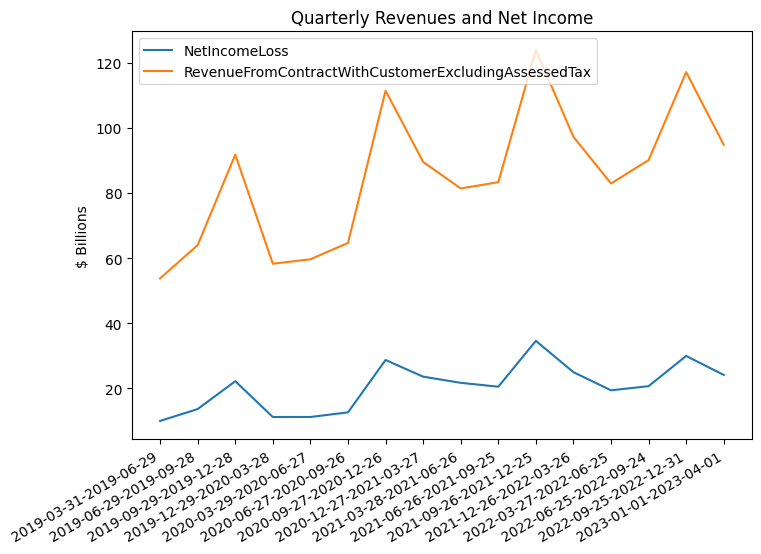

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tick


# custom y axis formatter
def format_dollars(y, pos=None):
    return int(y/1000000000)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float)\
                         .loc["NetIncomeLoss"]\
                         .plot.line(legend=True)
ax = qrt_income_statement.astype(float)\
                         .loc["RevenueFromContractWithCustomerExcludingAssessedTax"]\
                         .plot.line(legend=True)

ax.set_title('Quarterly Revenues and Net Income')

ax.yaxis.set_major_formatter(tick.FuncFormatter(format_dollars))

plt.ylabel('$ Billions')

# show all quarter date ranges
plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()

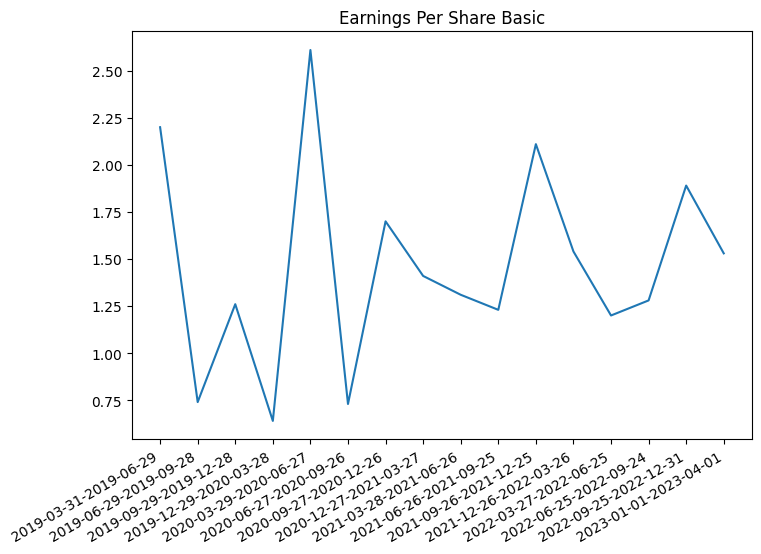

In [37]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float).loc["EarningsPerShareBasic"].plot.line()

ax.set_title('Earnings Per Share Basic')

# use higher precision for y axis labels
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()

In [39]:
# accession_numbers = ['0000320193-23-000006',
#  '0000320193-22-000108',
#  '0000320193-22-000070',
#  '0000320193-22-000059',
#  '0000320193-22-000007',
#  '0000320193-21-000105',
#  '0000320193-21-000065',
#  '0000320193-21-000056',
#  '0000320193-21-000010',
#  '0000320193-20-000096',
#  '0000320193-20-000062',
#  '0000320193-20-000052',
#  '0000320193-20-000010',
#  '0000320193-19-000119',
#  '0000320193-19-000076',
#  '0000320193-19-000066',
#  '0000320193-19-000010',
#  '0000320193-18-000145',
#  '0000320193-18-000100',
#  '0000320193-18-000070']

accession_numbers[0:12]

['0000320193-23-000064',
 '0000320193-23-000006',
 '0000320193-22-000108',
 '0000320193-22-000070',
 '0000320193-22-000059',
 '0000320193-22-000007',
 '0000320193-21-000105',
 '0000320193-21-000065',
 '0000320193-21-000056',
 '0000320193-21-000010',
 '0000320193-20-000096',
 '0000320193-20-000062']

In [40]:
# helps printing dataframes while we generate new income statement
from IPython.display import display, HTML

previous_income_statement_set = False
income_statement_final = None

for accession_no in accession_numbers:
# for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
    print('Processing: ' + accession_no)
    
    # get XBRL-JSON of 10-Q or 10-K filing by accession number
    # xbrl_json_data = get_xbrl_json(accession_no)
    xbrl_json_data = cacheDownload(f"datasets/balance_sheet_xbrl_{accession_no}",get_xbrl_json(accession_no)) #get_xbrl_json(accession_no)

    
    # convert XBRL-JSON to a pandas dataframe
    income_statement_uncleaned = get_income_statement(xbrl_json_data)

    # clean the income statement
    income_statement_cleaned = clean_income_statement(income_statement_uncleaned)
    
    # print income statement on each iteration to monitor progress
    display(HTML(income_statement_cleaned.to_html()))
    
    # merge new income statement with previously generated income statement
    if previous_income_statement_set:
        income_statement_final = clean_income_statement(merge_income_statements(income_statement_final, income_statement_cleaned))
    else:
        income_statement_final = income_statement_cleaned
        previous_income_statement_set = True

Processing: 0000320193-23-000064
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-23-000064


,2021-09-26-2022-03-26,2021-12-26-2022-03-26,2022-09-25-2023-04-01,2023-01-01-2023-04-01
RevenueFromContractWithCustomerExcludingAssessedTax,221223000000,97278000000,211990000000,94836000000
CostOfGoodsAndServicesSold,124421000000,54719000000,119682000000,52860000000
GrossProfit,96802000000,42559000000,92308000000,41976000000
ResearchAndDevelopmentExpense,12693000000,6387000000,15166000000,7457000000
SellingGeneralAndAdministrativeExpense,12642000000,6193000000,12808000000,6201000000
OperatingExpenses,25335000000,12580000000,27974000000,13658000000
OperatingIncomeLoss,71467000000,29979000000,64334000000,28318000000
NonoperatingIncomeExpense,-87000000,160000000,-329000000,64000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,71380000000,30139000000,64005000000,28382000000
IncomeTaxExpenseBenefit,11740000000,5129000000,9847000000,4222000000


Processing: 0000320193-23-000006
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-23-000006


,2021-09-26-2021-12-25,2022-09-25-2022-12-31
RevenueFromContractWithCustomerExcludingAssessedTax,123945000000,117154000000
CostOfGoodsAndServicesSold,69702000000,66822000000
GrossProfit,54243000000,50332000000
ResearchAndDevelopmentExpense,6306000000,7709000000
SellingGeneralAndAdministrativeExpense,6449000000,6607000000
OperatingExpenses,12755000000,14316000000
OperatingIncomeLoss,41488000000,36016000000
NonoperatingIncomeExpense,-247000000,-393000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,41241000000,35623000000
IncomeTaxExpenseBenefit,6611000000,5625000000


Processing: 0000320193-22-000108
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000108


,2019-09-29-2020-09-26,2020-09-27-2021-09-25,2021-09-26-2022-09-24
RevenueFromContractWithCustomerExcludingAssessedTax,274515000000,365817000000,394328000000
CostOfGoodsAndServicesSold,169559000000,212981000000,223546000000
GrossProfit,104956000000,152836000000,170782000000
ResearchAndDevelopmentExpense,18752000000,21914000000,26251000000
SellingGeneralAndAdministrativeExpense,19916000000,21973000000,25094000000
OperatingExpenses,38668000000,43887000000,51345000000
OperatingIncomeLoss,66288000000,108949000000,119437000000
NonoperatingIncomeExpense,803000000,258000000,-334000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,67091000000,109207000000,119103000000
IncomeTaxExpenseBenefit,9680000000,14527000000,19300000000


Processing: 0000320193-22-000070
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000070


,2020-09-27-2021-06-26,2021-03-28-2021-06-26,2021-09-26-2022-06-25,2022-03-27-2022-06-25
RevenueFromContractWithCustomerExcludingAssessedTax,282457000000,81434000000,304182000000,82959000000
CostOfGoodsAndServicesSold,164795000000,46179000000,171495000000,47074000000
GrossProfit,117662000000,35255000000,132687000000,35885000000
ResearchAndDevelopmentExpense,16142000000,5717000000,19490000000,6797000000
SellingGeneralAndAdministrativeExpense,16357000000,5412000000,18654000000,6012000000
OperatingExpenses,32499000000,11129000000,38144000000,12809000000
OperatingIncomeLoss,85163000000,24126000000,94543000000,23076000000
NonoperatingIncomeExpense,796000000,243000000,-97000000,-10000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,85959000000,24369000000,94446000000,23066000000
IncomeTaxExpenseBenefit,11830000000,2625000000,15364000000,3624000000


Processing: 0000320193-22-000059
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000059


,2020-09-27-2021-03-27,2020-12-27-2021-03-27,2021-09-26-2022-03-26,2021-12-26-2022-03-26
RevenueFromContractWithCustomerExcludingAssessedTax,201023000000,89584000000,221223000000,97278000000
CostOfGoodsAndServicesSold,118616000000,51505000000,124421000000,54719000000
GrossProfit,82407000000,38079000000,96802000000,42559000000
ResearchAndDevelopmentExpense,10425000000,5262000000,12693000000,6387000000
SellingGeneralAndAdministrativeExpense,10945000000,5314000000,12642000000,6193000000
OperatingExpenses,21370000000,10576000000,25335000000,12580000000
OperatingIncomeLoss,61037000000,27503000000,71467000000,29979000000
NonoperatingIncomeExpense,553000000,508000000,-87000000,160000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,61590000000,28011000000,71380000000,30139000000
IncomeTaxExpenseBenefit,9205000000,4381000000,11740000000,5129000000


Processing: 0000320193-22-000007
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000007


,2020-09-27-2020-12-26,2021-09-26-2021-12-25
RevenueFromContractWithCustomerExcludingAssessedTax,111439000000,123945000000
CostOfGoodsAndServicesSold,67111000000,69702000000
GrossProfit,44328000000,54243000000
ResearchAndDevelopmentExpense,5163000000,6306000000
SellingGeneralAndAdministrativeExpense,5631000000,6449000000
OperatingExpenses,10794000000,12755000000
OperatingIncomeLoss,33534000000,41488000000
NonoperatingIncomeExpense,45000000,-247000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,33579000000,41241000000
IncomeTaxExpenseBenefit,4824000000,6611000000


Processing: 0000320193-21-000105
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-21-000105


,2018-09-30-2019-09-28,2019-09-29-2020-09-26,2020-09-27-2021-09-25
RevenueFromContractWithCustomerExcludingAssessedTax,260174000000,274515000000,365817000000
CostOfGoodsAndServicesSold,161782000000,169559000000,212981000000
GrossProfit,98392000000,104956000000,152836000000
ResearchAndDevelopmentExpense,16217000000,18752000000,21914000000
SellingGeneralAndAdministrativeExpense,18245000000,19916000000,21973000000
OperatingExpenses,34462000000,38668000000,43887000000
OperatingIncomeLoss,63930000000,66288000000,108949000000
NonoperatingIncomeExpense,1807000000,803000000,258000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,65737000000,67091000000,109207000000
IncomeTaxExpenseBenefit,10481000000,9680000000,14527000000


Processing: 0000320193-21-000065
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-21-000065


,2019-09-29-2020-06-27,2020-03-29-2020-06-27,2020-09-27-2021-06-26,2021-03-28-2021-06-26
RevenueFromContractWithCustomerExcludingAssessedTax,209817000000,59685000000,282457000000,81434000000
CostOfGoodsAndServicesSold,129550000000,37005000000,164795000000,46179000000
GrossProfit,80267000000,22680000000,117662000000,35255000000
ResearchAndDevelopmentExpense,13774000000,4758000000,16142000000,5717000000
SellingGeneralAndAdministrativeExpense,14980000000,4831000000,16357000000,5412000000
OperatingExpenses,28754000000,9589000000,32499000000,11129000000
OperatingIncomeLoss,51513000000,13091000000,85163000000,24126000000
NonoperatingIncomeExpense,677000000,46000000,796000000,243000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,52190000000,13137000000,85959000000,24369000000
IncomeTaxExpenseBenefit,7452000000,1884000000,11830000000,2625000000


Processing: 0000320193-21-000056
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-21-000056


,2019-09-29-2020-03-28,2019-12-29-2020-03-28,2020-09-27-2021-03-27,2020-12-27-2021-03-27
RevenueFromContractWithCustomerExcludingAssessedTax,150132000000,58313000000,201023000000,89584000000
CostOfGoodsAndServicesSold,92545000000,35943000000,118616000000,51505000000
GrossProfit,57587000000,22370000000,82407000000,38079000000
ResearchAndDevelopmentExpense,9016000000,4565000000,10425000000,5262000000
SellingGeneralAndAdministrativeExpense,10149000000,4952000000,10945000000,5314000000
OperatingExpenses,19165000000,9517000000,21370000000,10576000000
OperatingIncomeLoss,38422000000,12853000000,61037000000,27503000000
NonoperatingIncomeExpense,631000000,282000000,553000000,508000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,39053000000,13135000000,61590000000,28011000000
IncomeTaxExpenseBenefit,5568000000,1886000000,9205000000,4381000000


Processing: 0000320193-21-000010
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-21-000010


,2019-09-29-2019-12-28,2020-09-27-2020-12-26
RevenueFromContractWithCustomerExcludingAssessedTax,91819000000,111439000000
CostOfGoodsAndServicesSold,56602000000,67111000000
GrossProfit,35217000000,44328000000
ResearchAndDevelopmentExpense,4451000000,5163000000
SellingGeneralAndAdministrativeExpense,5197000000,5631000000
OperatingExpenses,9648000000,10794000000
OperatingIncomeLoss,25569000000,33534000000
NonoperatingIncomeExpense,349000000,45000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,25918000000,33579000000
IncomeTaxExpenseBenefit,3682000000,4824000000


Processing: 0000320193-20-000096
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-20-000096


,2017-10-01-2018-09-29,2018-09-30-2019-09-28,2019-09-29-2020-09-26
RevenueFromContractWithCustomerExcludingAssessedTax,265595000000,260174000000,274515000000
CostOfGoodsAndServicesSold,163756000000,161782000000,169559000000
GrossProfit,101839000000,98392000000,104956000000
ResearchAndDevelopmentExpense,14236000000,16217000000,18752000000
SellingGeneralAndAdministrativeExpense,16705000000,18245000000,19916000000
OperatingExpenses,30941000000,34462000000,38668000000
OperatingIncomeLoss,70898000000,63930000000,66288000000
NonoperatingIncomeExpense,2005000000,1807000000,803000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,72903000000,65737000000,67091000000
IncomeTaxExpenseBenefit,13372000000,10481000000,9680000000


Processing: 0000320193-20-000062
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-20-000062


,2018-09-30-2019-06-29,2019-03-31-2019-06-29,2019-09-29-2020-06-27,2020-03-29-2020-06-27
RevenueFromContractWithCustomerExcludingAssessedTax,196134000000,53809000000,209817000000,59685000000
CostOfGoodsAndServicesSold,122055000000,33582000000,129550000000,37005000000
GrossProfit,74079000000,20227000000,80267000000,22680000000
ResearchAndDevelopmentExpense,12107000000,4257000000,13774000000,4758000000
SellingGeneralAndAdministrativeExpense,13667000000,4426000000,14980000000,4831000000
OperatingExpenses,25774000000,8683000000,28754000000,9589000000
OperatingIncomeLoss,48305000000,11544000000,51513000000,13091000000
NonoperatingIncomeExpense,1305000000,367000000,677000000,46000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,49610000000,11911000000,52190000000,13137000000
IncomeTaxExpenseBenefit,8040000000,1867000000,7452000000,1884000000


Processing: 0000320193-20-000052
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-20-000052


,2018-09-30-2019-03-30,2018-12-30-2019-03-30,2019-09-29-2020-03-28,2019-12-29-2020-03-28
RevenueFromContractWithCustomerExcludingAssessedTax,142325000000,58015000000,150132000000,58313000000
CostOfGoodsAndServicesSold,88473000000,36194000000,92545000000,35943000000
GrossProfit,53852000000,21821000000,57587000000,22370000000
ResearchAndDevelopmentExpense,7850000000,3948000000,9016000000,4565000000
SellingGeneralAndAdministrativeExpense,9241000000,4458000000,10149000000,4952000000
OperatingExpenses,17091000000,8406000000,19165000000,9517000000
OperatingIncomeLoss,36761000000,13415000000,38422000000,12853000000
NonoperatingIncomeExpense,938000000,378000000,631000000,282000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,37699000000,13793000000,39053000000,13135000000
IncomeTaxExpenseBenefit,6173000000,2232000000,5568000000,1886000000


Processing: 0000320193-20-000010
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-20-000010


,2018-09-30-2018-12-29,2019-09-29-2019-12-28
RevenueFromContractWithCustomerExcludingAssessedTax,84310000000,91819000000
CostOfGoodsAndServicesSold,52279000000,56602000000
GrossProfit,32031000000,35217000000
ResearchAndDevelopmentExpense,3902000000,4451000000
SellingGeneralAndAdministrativeExpense,4783000000,5197000000
OperatingExpenses,8685000000,9648000000
OperatingIncomeLoss,23346000000,25569000000
NonoperatingIncomeExpense,560000000,349000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,23906000000,25918000000
IncomeTaxExpenseBenefit,3941000000,3682000000


Processing: 0000320193-19-000119
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-19-000119


,2016-09-25-2017-09-30,2017-10-01-2018-09-29,2018-09-30-2019-09-28
RevenueFromContractWithCustomerExcludingAssessedTax,229234000000,265595000000,260174000000
CostOfGoodsAndServicesSold,141048000000,163756000000,161782000000
GrossProfit,88186000000,101839000000,98392000000
ResearchAndDevelopmentExpense,11581000000,14236000000,16217000000
SellingGeneralAndAdministrativeExpense,15261000000,16705000000,18245000000
OperatingExpenses,26842000000,30941000000,34462000000
OperatingIncomeLoss,61344000000,70898000000,63930000000
NonoperatingIncomeExpense,2745000000,2005000000,1807000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,64089000000,72903000000,65737000000
IncomeTaxExpenseBenefit,15738000000,13372000000,10481000000


Processing: 0000320193-19-000076
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-19-000076


,2017-10-01-2018-06-30,2018-04-01-2018-06-30,2018-09-30-2019-06-29,2019-03-31-2019-06-29
RevenueFromContractWithCustomerExcludingAssessedTax,202695000000,53265000000,196134000000,53809000000
CostOfGoodsAndServicesSold,124940000000,32844000000,122055000000,33582000000
GrossProfit,77755000000,20421000000,74079000000,20227000000
ResearchAndDevelopmentExpense,10486000000,3701000000,12107000000,4257000000
SellingGeneralAndAdministrativeExpense,12489000000,4108000000,13667000000,4426000000
OperatingExpenses,22975000000,7809000000,25774000000,8683000000
OperatingIncomeLoss,54780000000,12612000000,48305000000,11544000000
NonoperatingIncomeExpense,1702000000,672000000,1305000000,367000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,56482000000,13284000000,49610000000,11911000000
IncomeTaxExpenseBenefit,11076000000,1765000000,8040000000,1867000000


Processing: 0000320193-19-000066
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-19-000066


,2017-10-01-2018-03-31,2017-12-31-2018-03-31,2018-09-30-2019-03-30,2018-12-30-2019-03-30
RevenueFromContractWithCustomerExcludingAssessedTax,149430000000,61137000000,142325000000,58015000000
CostOfGoodsAndServicesSold,92096000000,37715000000,88473000000,36194000000
GrossProfit,57334000000,23422000000,53852000000,21821000000
ResearchAndDevelopmentExpense,6785000000,3378000000,7850000000,3948000000
SellingGeneralAndAdministrativeExpense,8381000000,4150000000,9241000000,4458000000
OperatingExpenses,15166000000,7528000000,17091000000,8406000000
OperatingIncomeLoss,42168000000,15894000000,36761000000,13415000000
NonoperatingIncomeExpense,1030000000,274000000,938000000,378000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,43198000000,16168000000,37699000000,13793000000
IncomeTaxExpenseBenefit,9311000000,2346000000,6173000000,2232000000


Processing: 0000320193-19-000010
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-19-000010


,2017-10-01-2017-12-30,2018-09-30-2018-12-29
RevenueFromContractWithCustomerExcludingAssessedTax,88293000000,84310000000
CostOfGoodsAndServicesSold,54381000000,52279000000
GrossProfit,33912000000,32031000000
ResearchAndDevelopmentExpense,3407000000,3902000000
SellingGeneralAndAdministrativeExpense,4231000000,4783000000
OperatingExpenses,7638000000,8685000000
OperatingIncomeLoss,26274000000,23346000000
NonoperatingIncomeExpense,756000000,560000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,27030000000,23906000000
IncomeTaxExpenseBenefit,6965000000,3941000000


Processing: 0000320193-18-000145
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-18-000145


,2015-09-27-2016-09-24,2016-09-25-2017-09-30,2017-10-01-2018-09-29
Revenues,215639000000,229234000000,265595000000
CostOfGoodsAndServicesSold,131376000000,141048000000,163756000000
GrossProfit,84263000000,88186000000,101839000000
ResearchAndDevelopmentExpense,10045000000,11581000000,14236000000
SellingGeneralAndAdministrativeExpense,14194000000,15261000000,16705000000
OperatingExpenses,24239000000,26842000000,30941000000
OperatingIncomeLoss,60024000000,61344000000,70898000000
NonoperatingIncomeExpense,1348000000,2745000000,2005000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,61372000000,64089000000,72903000000
IncomeTaxExpenseBenefit,15685000000,15738000000,13372000000


Processing: 0000320193-18-000100
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-18-000100


,2016-09-25-2017-07-01,2017-04-02-2017-07-01,2017-10-01-2018-06-30,2018-04-01-2018-06-30
SalesRevenueNet,176655000000,45408000000,202695000000,53265000000
CostOfGoodsAndServicesSold,108400000000,27920000000,124940000000,32844000000
GrossProfit,68255000000,17488000000,77755000000,20421000000
ResearchAndDevelopmentExpense,8584000000,2937000000,10486000000,3701000000
SellingGeneralAndAdministrativeExpense,11447000000,3783000000,12489000000,4108000000
OperatingExpenses,20031000000,6720000000,22975000000,7809000000
OperatingIncomeLoss,48224000000,10768000000,54780000000,12612000000
NonoperatingIncomeExpense,1948000000,540000000,1702000000,672000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,50172000000,11308000000,56482000000,13284000000
IncomeTaxExpenseBenefit,12535000000,2591000000,11076000000,1765000000


In [41]:
income_statement_final

,2015-09-27-2016-09-24,2016-09-25-2017-07-01,2016-09-25-2017-09-30,2017-04-02-2017-07-01,2017-10-01-2017-12-30,2017-10-01-2018-03-31,2017-10-01-2018-06-30,2017-10-01-2018-09-29,2017-12-31-2018-03-31,2018-04-01-2018-06-30,...,2021-03-28-2021-06-26,2021-09-26-2021-12-25,2021-09-26-2022-03-26,2021-09-26-2022-06-25,2021-09-26-2022-09-24,2021-12-26-2022-03-26,2022-03-27-2022-06-25,2022-09-25-2022-12-31,2022-09-25-2023-04-01,2023-01-01-2023-04-01
NaN,NaN,NaN,NaN,NaN,88293000000,149430000000,NaN,NaN,61137000000,NaN,...,81434000000,123945000000,221223000000,304182000000,394328000000,97278000000,82959000000,117154000000,211990000000,94836000000
CostOfGoodsAndServicesSold,131376000000,108400000000,141048000000,27920000000,54381000000,92096000000,124940000000,163756000000,37715000000,32844000000,...,46179000000,69702000000,124421000000,171495000000,223546000000,54719000000,47074000000,66822000000,119682000000,52860000000
GrossProfit,84263000000,68255000000,88186000000,17488000000,33912000000,57334000000,77755000000,101839000000,23422000000,20421000000,...,35255000000,54243000000,96802000000,132687000000,170782000000,42559000000,35885000000,50332000000,92308000000,41976000000
ResearchAndDevelopmentExpense,10045000000,8584000000,11581000000,2937000000,3407000000,6785000000,10486000000,14236000000,3378000000,3701000000,...,5717000000,6306000000,12693000000,19490000000,26251000000,6387000000,6797000000,7709000000,15166000000,7457000000
SellingGeneralAndAdministrativeExpense,14194000000,11447000000,15261000000,3783000000,4231000000,8381000000,12489000000,16705000000,4150000000,4108000000,...,5412000000,6449000000,12642000000,18654000000,25094000000,6193000000,6012000000,6607000000,12808000000,6201000000
OperatingExpenses,24239000000,20031000000,26842000000,6720000000,7638000000,15166000000,22975000000,30941000000,7528000000,7809000000,...,11129000000,12755000000,25335000000,38144000000,51345000000,12580000000,12809000000,14316000000,27974000000,13658000000
OperatingIncomeLoss,60024000000,48224000000,61344000000,10768000000,26274000000,42168000000,54780000000,70898000000,15894000000,12612000000,...,24126000000,41488000000,71467000000,94543000000,119437000000,29979000000,23076000000,36016000000,64334000000,28318000000
NonoperatingIncomeExpense,1348000000,1948000000,2745000000,540000000,756000000,1030000000,1702000000,2005000000,274000000,672000000,...,243000000,-247000000,-87000000,-97000000,-334000000,160000000,-10000000,-393000000,-329000000,64000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,61372000000,50172000000,64089000000,11308000000,27030000000,43198000000,56482000000,72903000000,16168000000,13284000000,...,24369000000,41241000000,71380000000,94446000000,119103000000,30139000000,23066000000,35623000000,64005000000,28382000000
IncomeTaxExpenseBenefit,15685000000,12535000000,15738000000,2591000000,6965000000,9311000000,11076000000,13372000000,2346000000,1765000000,...,2625000000,6611000000,11740000000,15364000000,19300000000,5129000000,3624000000,5625000000,9847000000,4222000000


In [57]:
statement = income_statement_final
statement_1 = add_fourth_quarter_results(statement)

qrt_income_statement = only_quarterly_results(statement_1)
qrt_income_statement

['2015', '09', '27', '2016', '09', '24']
['2016', '09', '25', '2017', '07', '01']
['2016', '09', '25', '2017', '09', '30']
Trying 

2016-09-25-2017-09-30 nan 2016-09-25-2017-07-01
<class 'float'>
Trying 

2016-09-25-2017-09-30 CostOfGoodsAndServicesSold 2016-09-25-2017-07-01
<class 'str'>
Trying 

2016-09-25-2017-09-30 GrossProfit 2016-09-25-2017-07-01
<class 'str'>
Trying 

2016-09-25-2017-09-30 ResearchAndDevelopmentExpense 2016-09-25-2017-07-01
<class 'str'>
Trying 

2016-09-25-2017-09-30 SellingGeneralAndAdministrativeExpense 2016-09-25-2017-07-01
<class 'str'>
Trying 

2016-09-25-2017-09-30 OperatingExpenses 2016-09-25-2017-07-01
<class 'str'>
Trying 

2016-09-25-2017-09-30 OperatingIncomeLoss 2016-09-25-2017-07-01
<class 'str'>
Trying 

2016-09-25-2017-09-30 NonoperatingIncomeExpense 2016-09-25-2017-07-01
<class 'str'>
Trying 

2016-09-25-2017-09-30 IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest 2016-09-25-2017-07-01
<class 'str'>
Tryi

C:\Users\moyer\AppData\Local\Temp\ipykernel_4152\3360083010.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, row_value in statement[column].iteritems():
C:\Users\moyer\AppData\Local\Temp\ipykernel_4152\3360083010.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, row_value in statement[column].iteritems():
C:\Users\moyer\AppData\Local\Temp\ipykernel_4152\3360083010.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, row_value in statement[column].iteritems():
C:\Users\moyer\AppData\Local\Temp\ipykernel_4152\3360083010.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, row_value in statement[column].iteritems():
C:\Users\moyer\AppData\Local\Temp\ipykernel_4152\3360083010.py:40: FutureWarning: iteritems is d

,2017-04-02-2017-07-01,2017-07-01-2017-09-30,2017-10-01-2017-12-30,2017-12-31-2018-03-31,2018-04-01-2018-06-30,2018-06-30-2018-09-29,2018-09-30-2018-12-29,2018-12-30-2019-03-30,2019-03-31-2019-06-29,2019-06-29-2019-09-28,...,2020-09-27-2020-12-26,2020-12-27-2021-03-27,2021-03-28-2021-06-26,2021-06-26-2021-09-25,2021-09-26-2021-12-25,2021-12-26-2022-03-26,2022-03-27-2022-06-25,2022-06-25-2022-09-24,2022-09-25-2022-12-31,2023-01-01-2023-04-01
NaN,NaN,nan,88293000000,61137000000,NaN,nan,84310000000,58015000000,53809000000,64040000000,...,111439000000,89584000000,81434000000,83360000000,123945000000,97278000000,82959000000,90146000000,117154000000,94836000000
CostOfGoodsAndServicesSold,27920000000,32648000000,54381000000,37715000000,32844000000,38816000000,52279000000,36194000000,33582000000,39727000000,...,67111000000,51505000000,46179000000,48186000000,69702000000,54719000000,47074000000,52051000000,66822000000,52860000000
GrossProfit,17488000000,19931000000,33912000000,23422000000,20421000000,24084000000,32031000000,21821000000,20227000000,24313000000,...,44328000000,38079000000,35255000000,35174000000,54243000000,42559000000,35885000000,38095000000,50332000000,41976000000
ResearchAndDevelopmentExpense,2937000000,2997000000,3407000000,3378000000,3701000000,3750000000,3902000000,3948000000,4257000000,4110000000,...,5163000000,5262000000,5717000000,5772000000,6306000000,6387000000,6797000000,6761000000,7709000000,7457000000
SellingGeneralAndAdministrativeExpense,3783000000,3814000000,4231000000,4150000000,4108000000,4216000000,4783000000,4458000000,4426000000,4578000000,...,5631000000,5314000000,5412000000,5616000000,6449000000,6193000000,6012000000,6440000000,6607000000,6201000000
OperatingExpenses,6720000000,6811000000,7638000000,7528000000,7809000000,7966000000,8685000000,8406000000,8683000000,8688000000,...,10794000000,10576000000,11129000000,11388000000,12755000000,12580000000,12809000000,13201000000,14316000000,13658000000
OperatingIncomeLoss,10768000000,13120000000,26274000000,15894000000,12612000000,16118000000,23346000000,13415000000,11544000000,15625000000,...,33534000000,27503000000,24126000000,23786000000,41488000000,29979000000,23076000000,24894000000,36016000000,28318000000
NonoperatingIncomeExpense,540000000,797000000,756000000,274000000,672000000,303000000,560000000,378000000,367000000,502000000,...,45000000,508000000,243000000,-538000000,-247000000,160000000,-10000000,-237000000,-393000000,64000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,11308000000,13917000000,27030000000,16168000000,13284000000,16421000000,23906000000,13793000000,11911000000,16127000000,...,33579000000,28011000000,24369000000,23248000000,41241000000,30139000000,23066000000,24657000000,35623000000,28382000000
IncomeTaxExpenseBenefit,2591000000,3203000000,6965000000,2346000000,1765000000,2296000000,3941000000,2232000000,1867000000,2441000000,...,4824000000,4381000000,2625000000,2697000000,6611000000,5129000000,3624000000,3936000000,5625000000,4222000000


In [50]:
def clean_balance_sheet(statement):
    for column in statement:

        # column has more than 5 NaN values
        is_nan_column = statement[column].isna().sum() > 5

        if column.endswith('_left') or column == 'key_0' or is_nan_column:
            statement = statement.drop(column, axis=1)
    
    # rearrange columns so that first column represents first quarter
    # e.g. 2018, 2019, 2020 - and not 2020, 2019, 2018
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [69]:
# xbrl_json_data_0 = get_xbrl_json(accession_numbers[0])
# balance_sheet_uncleaned_0 = get_balance_sheet(xbrl_json_data)
# # balance_sheet_uncleaned.tail(50)

# balance_sheet_cleaned_0 = clean_balance_sheet(balance_sheet_uncleaned_0)
# balance_sheet_cleaned_0

def getSheet(accession_no):
    xbrl_json_data = cacheDownload(f"datasets/balance_sheet_xbrl_{accession_no}",get_xbrl_json(accession_no))
    balance_sheet_uncleaned = get_balance_sheet(xbrl_json_data)

    # clean the income statement
    balance_sheet_cleaned = clean_income_statement(balance_sheet_uncleaned)
    return balance_sheet_cleaned



In [63]:
df1 = getSheet("0000320193-23-000006")
df2 = getSheet("0000320193-22-000108")

file path exists, loading: datasets/balance_sheet_xbrl_0000320193-23-000006
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000108


In [68]:
clean_income_statement(merge_income_statements(df1,df2))

,2021-09-25,2022-09-24,2022-12-31
CashAndCashEquivalentsAtCarryingValue,34940000000,23646000000,20535000000
MarketableSecuritiesCurrent,27699000000,24658000000,30820000000
AccountsReceivableNetCurrent,26278000000,28184000000,23752000000
InventoryNet,6580000000,4946000000,6820000000
NontradeReceivablesCurrent,25228000000,32748000000,30428000000
OtherAssetsCurrent,14111000000,21223000000,16422000000
AssetsCurrent,134836000000,135405000000,128777000000
MarketableSecuritiesNoncurrent,127877000000,120805000000,114095000000
PropertyPlantAndEquipmentNet,39440000000,42117000000,42951000000
OtherAssetsNoncurrent,48849000000,54428000000,60924000000


In [47]:
xbrl_json_data_3 = get_xbrl_json(accession_numbers[3])
balance_sheet_uncleaned_3 = get_balance_sheet(xbrl_json_data)
# balance_sheet_uncleaned.tail(50)

balance_sheet_cleaned_3 = clean_balance_sheet(balance_sheet_uncleaned_3)
balance_sheet_cleaned_3

,2019-09-28,2020-03-28
CashAndCashEquivalentsAtCarryingValue,48844000000,40174000000
MarketableSecuritiesCurrent,51713000000,53877000000
AccountsReceivableNetCurrent,22926000000,15722000000
InventoryNet,4106000000,3334000000
NontradeReceivablesCurrent,22878000000,14955000000
OtherAssetsCurrent,12352000000,15691000000
AssetsCurrent,162819000000,143753000000
MarketableSecuritiesNoncurrent,105341000000,98793000000
PropertyPlantAndEquipmentNet,37378000000,35889000000
OtherAssetsNoncurrent,32978000000,41965000000


In [54]:
# xbrl_json_data_4 = get_xbrl_json(accession_numbers[4])
balance_sheet_uncleaned_4 = get_balance_sheet(xbrl_json_data)
# balance_sheet_uncleaned.tail(50)

balance_sheet_cleaned_4 = clean_balance_sheet(balance_sheet_uncleaned_4)
balance_sheet_cleaned_4
balance_sheet_uncleaned_4

,2018-09-29,2018-12-29,2019-03-30,2019-09-28,2019-12-28,2020-03-28
CashAndCashEquivalentsAtCarryingValue,NaN,NaN,NaN,48844000000,NaN,40174000000
MarketableSecuritiesCurrent,NaN,NaN,NaN,51713000000,NaN,53877000000
AccountsReceivableNetCurrent,NaN,NaN,NaN,22926000000,NaN,15722000000
InventoryNet,NaN,NaN,NaN,4106000000,NaN,3334000000
NontradeReceivablesCurrent,NaN,NaN,NaN,22878000000,NaN,14955000000
OtherAssetsCurrent,NaN,NaN,NaN,12352000000,NaN,15691000000
AssetsCurrent,NaN,NaN,NaN,162819000000,NaN,143753000000
MarketableSecuritiesNoncurrent,NaN,NaN,NaN,105341000000,NaN,98793000000
PropertyPlantAndEquipmentNet,NaN,NaN,NaN,37378000000,NaN,35889000000
OtherAssetsNoncurrent,NaN,NaN,NaN,32978000000,NaN,41965000000


In [1]:
# xbrl_json_data_6 = get_xbrl_json(accession_numbers[6])
balance_sheet_uncleaned_6 = get_balance_sheet(xbrl_json_data_6)
# balance_sheet_uncleaned.tail(50)

balance_sheet_cleaned_6 = clean_balance_sheet(balance_sheet_uncleaned_6)
# balance_sheet_cleaned_6
balance_sheet_uncleaned_6

NameError: name 'get_balance_sheet' is not defined

In [ ]:
xbrl_json_data_7 = get_xbrl_json(accession_numbers[7])
balance_sheet_uncleaned_7 = get_balance_sheet(xbrl_json_data_7)
# balance_sheet_uncleaned.tail(50)

balance_sheet_cleaned_7 = clean_balance_sheet(balance_sheet_uncleaned_7)
balance_sheet_cleaned_7

,2020-09-26,2021-03-27
CashAndCashEquivalentsAtCarryingValue,38016000000,38466000000
MarketableSecuritiesCurrent,52927000000,31368000000
AccountsReceivableNetCurrent,16120000000,18503000000
InventoryNet,4061000000,5219000000
NontradeReceivablesCurrent,21325000000,14533000000
OtherAssetsCurrent,11264000000,13376000000
AssetsCurrent,143713000000,121465000000
MarketableSecuritiesNoncurrent,100887000000,134539000000
PropertyPlantAndEquipmentNet,36766000000,37815000000
OtherAssetsNoncurrent,42522000000,43339000000


In [61]:
clean_balance_sheet(merge_income_statements(balance_sheet_cleaned_2, balance_sheet_cleaned_3))

,2019-09-28,2020-03-28
CashAndCashEquivalentsAtCarryingValue,48844000000,40174000000
MarketableSecuritiesCurrent,51713000000,53877000000
AccountsReceivableNetCurrent,22926000000,15722000000
InventoryNet,4106000000,3334000000
NontradeReceivablesCurrent,22878000000,14955000000
OtherAssetsCurrent,12352000000,15691000000
AssetsCurrent,162819000000,143753000000
MarketableSecuritiesNoncurrent,105341000000,98793000000
PropertyPlantAndEquipmentNet,37378000000,35889000000
OtherAssetsNoncurrent,32978000000,41965000000


In [83]:
# helps printing dataframes while we generate new income statement
from IPython.display import display, HTML

previous_balance_sheet = False
balance_sheet_final = None

for accession_no in accession_numbers:
# for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
    print('Processing Balance Sheet: ' + accession_no)
    
    # get XBRL-JSON of 10-Q or 10-K filing by accession number
    
    xbrl_json_data = cacheDownload(f"datasets/balance_sheet_xbrl_{accession_no}",get_xbrl_json(accession_no)) #get_xbrl_json(accession_no)
    
    # convert XBRL-JSON to a pandas dataframe
    balance_sheet_uncleaned = get_balance_sheet(xbrl_json_data)

    # clean the income statement
    balance_sheet_cleaned = clean_income_statement(balance_sheet_uncleaned)
    print("---Cleaned sheet has: " + str(len(balance_sheet_cleaned.columns)))
    print(f"---Cleaned Cols {balance_sheet_cleaned.columns}")

    
    # print income statement on each iteration to monitor progress
    # display(HTML(income_statement_cleaned.to_html()))
    
    # merge new income statement with previously generated income statement
    skip_index = False
    for date_index in list(balance_sheet_cleaned.columns):
        if (date_index[0:4] == '2017'):
            print("---Found 2017 date, not merging")
            skip_index = True
            break
    if (not skip_index):
        if previous_balance_sheet:
            print("---Merging previous df: " + str(len(balance_sheet_final.columns)))
            balance_sheet_final = clean_income_statement(merge_income_statements(balance_sheet_final, balance_sheet_uncleaned))
            print(balance_sheet_final.columns)
        else:
            balance_sheet_final = balance_sheet_cleaned
            print("---Setting initial df: " + str(len(balance_sheet_final.columns)))
            previous_balance_sheet = True

Processing Balance Sheet: 0000320193-23-000006
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-23-000006
---Cleaned sheet has: 2
---Cleaned Cols Index(['2022-09-24', '2022-12-31'], dtype='object')
---Setting initial df: 2
Processing Balance Sheet: 0000320193-22-000108
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000108
---Cleaned sheet has: 2
---Cleaned Cols Index(['2021-09-25', '2022-09-24'], dtype='object')
---Merging previous df: 2
Index(['2021-09-25', '2022-09-24', '2022-12-31'], dtype='object')
Processing Balance Sheet: 0000320193-22-000070
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000070
---Cleaned sheet has: 2
---Cleaned Cols Index(['2021-09-25', '2022-06-25'], dtype='object')
---Merging previous df: 3
Index(['2021-09-25', '2022-06-25', '2022-09-24', '2022-12-31'], dtype='object')
Processing Balance Sheet: 0000320193-22-000059
file path exists, loading: datasets/balance_sheet_xbrl_0000320193-22-000059
---Cleane

In [28]:
def cacheDownload(file_path,download_function):
    df = None
    if (os.path.exists(file_path)):
        print(f"file path exists, loading: {file_path}")
        if (type(df) is dict):
            df = loadDict(file_path)
        else:
            df = pd.read_pickle(file_path)
    else:
        df = download_function
        if (type(df) is dict):
            saveDict(file_path,df)
        else:
            df.to_pickle(file_path)
        print(f"Saved df to {file_path}")
    return df

def saveDict(file_path, dict_obj):
    with open(file_path, 'wb') as handle:
        pickle.dump(dict_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadDict(file_path):
    with open(file_path, 'rb') as handle:
        b = pickle.load(handle)
        return b



In [82]:


for date_index in list(balance_sheet_cleaned.columns):
    if (date_index[0:4] == '2017'):
        print("---Found 2017 date, not merging")

---Found 2017 date, not merging


In [84]:
balance_sheet_final

,2018-09-29,2018-12-29,2019-03-30,2019-06-29,2019-09-28,2019-12-28,2020-03-28,2020-06-27,2020-09-26,2020-12-26,2021-03-27,2021-06-26,2021-09-25,2021-12-25,2022-03-26,2022-06-25,2022-09-24,2022-12-31
CashAndCashEquivalentsAtCarryingValue,25913000000,44771000000,37988000000,50530000000,48844000000,39771000000,40174000000,33383000000,38016000000,36010000000,38466000000,34050000000,34940000000,37119000000,28098000000,27502000000,23646000000,20535000000
MarketableSecuritiesCurrent,40388000000,41656000000,42104000000,44084000000,51713000000,67391000000,53877000000,59642000000,52927000000,40816000000,31368000000,27646000000,27699000000,26794000000,23413000000,20729000000,24658000000,30820000000
AccountsReceivableNetCurrent,23186000000,18077000000,15085000000,14148000000,22926000000,20970000000,15722000000,17882000000,16120000000,27101000000,18503000000,17475000000,26278000000,30213000000,20815000000,21803000000,28184000000,23752000000
InventoryNet,3956000000,4988000000,4884000000,3355000000,4106000000,4097000000,3334000000,3978000000,4061000000,4973000000,5219000000,5178000000,6580000000,5876000000,5460000000,5433000000,4946000000,6820000000
NontradeReceivablesCurrent,25809000000,18904000000,11193000000,12326000000,22878000000,18976000000,14955000000,14193000000,21325000000,31519000000,14533000000,16433000000,25228000000,35040000000,24585000000,20439000000,32748000000,30428000000
OtherAssetsCurrent,12087000000,12432000000,12092000000,10530000000,12352000000,12026000000,15691000000,10987000000,11264000000,13687000000,13376000000,13641000000,14111000000,18112000000,15809000000,16386000000,21223000000,16422000000
AssetsCurrent,131339000000,140828000000,123346000000,134973000000,162819000000,163231000000,143753000000,140065000000,143713000000,154106000000,121465000000,114423000000,134836000000,153154000000,118180000000,112292000000,135405000000,128777000000
MarketableSecuritiesNoncurrent,170799000000,158608000000,145319000000,115996000000,105341000000,99899000000,98793000000,100592000000,100887000000,118745000000,134539000000,131948000000,127877000000,138683000000,141219000000,131077000000,120805000000,114095000000
PropertyPlantAndEquipmentNet,41304000000,39597000000,38746000000,37636000000,37378000000,37031000000,35889000000,35687000000,36766000000,37933000000,37815000000,38615000000,39440000000,39245000000,39304000000,40335000000,42117000000,42951000000
OtherAssetsNoncurrent,22283000000,34686000000,34587000000,33634000000,32978000000,40457000000,41965000000,41000000000,42522000000,43270000000,43339000000,44854000000,48849000000,50109000000,51959000000,52605000000,54428000000,60924000000


In [87]:
statement = balance_sheet_final
statement_1 = add_fourth_quarter_results(statement)

['2018', '09', '29']


IndexError: list index out of range

In [39]:
df

NameError: name 'df' is not defined